# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from imports import *
from structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

#df_raw = pd.read_feather('tmp/raw')
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [7]:
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20591475722062552, 0.2487392058549012, 0.9113844840544845, 0.889506568614042, 0.8943942822380935]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [9]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 3.68 s


(9.236148016697461, 0.19248014048908452)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [10]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(9.236148016697461, 0.19248014048908452)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

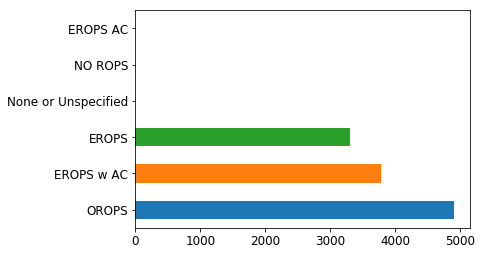

In [11]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [12]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.841909,0.271171
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.580067,0.263979
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.685130,0.222342


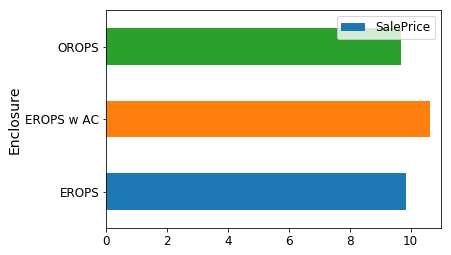

In [13]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

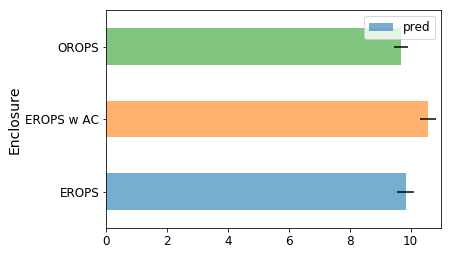

In [14]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

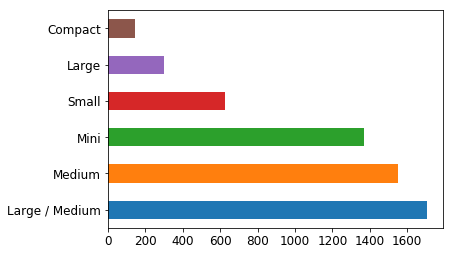

In [15]:
raw_valid.ProductSize.value_counts().plot.barh();

In [16]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.845119,0.335827
Large,10.470589,10.388601,0.352800
Large / Medium,10.691871,10.651468,0.293563
Medium,10.681511,10.623257,0.287047
Mini,9.535147,9.560204,0.242246
Small,10.324448,10.328430,0.311851


In [17]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034111
Large             0.033960
Small             0.030193
Large / Medium    0.027561
Medium            0.027021
Mini              0.025339
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [18]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.171187
37,Coupler_System,0.096896
13,ProductSize,0.096402
14,fiProductClassDesc,0.087887
2,ModelID,0.059137
38,Grouser_Tracks,0.050675
63,saleElapsed,0.049538
10,fiSecondaryDesc,0.045520
19,Enclosure,0.043687
39,Hydraulics_Flow,0.036600


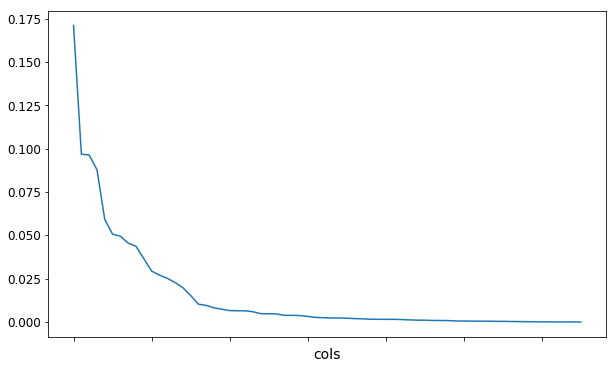

In [19]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [20]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

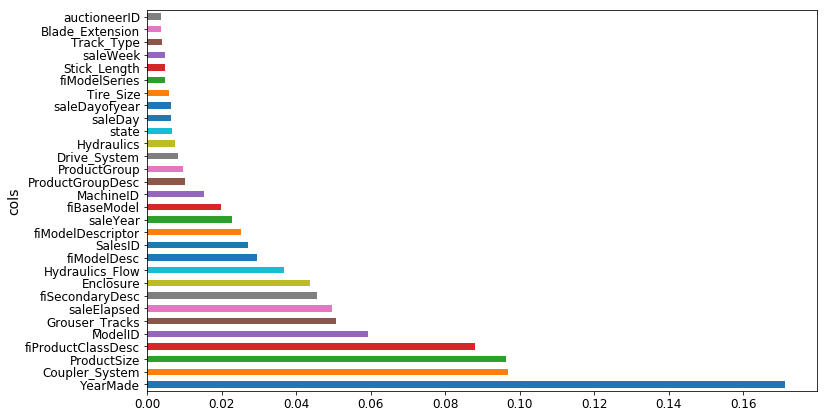

In [21]:
plot_fi(fi[:30]);

In [22]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [23]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [24]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20718953237479049, 0.24580953160960883, 0.9102838875705431, 0.8920940450577625, 0.8938525814294412]


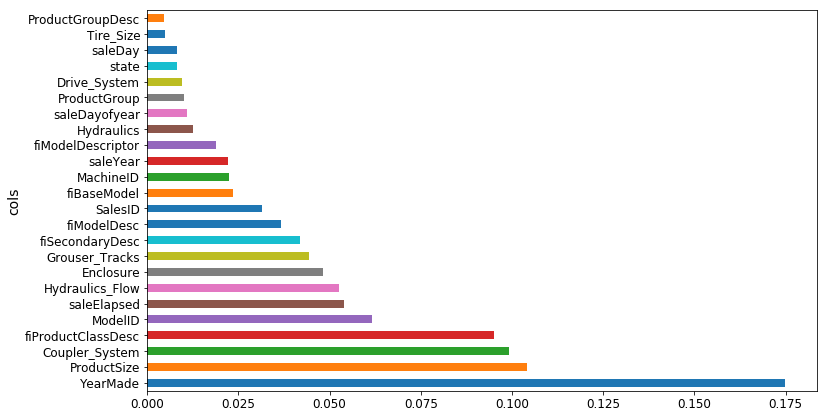

In [25]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

In [26]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20748957581672783, 0.2536741538722671, 0.9100238529812775, 0.8850787304865521, 0.8923012390969451]


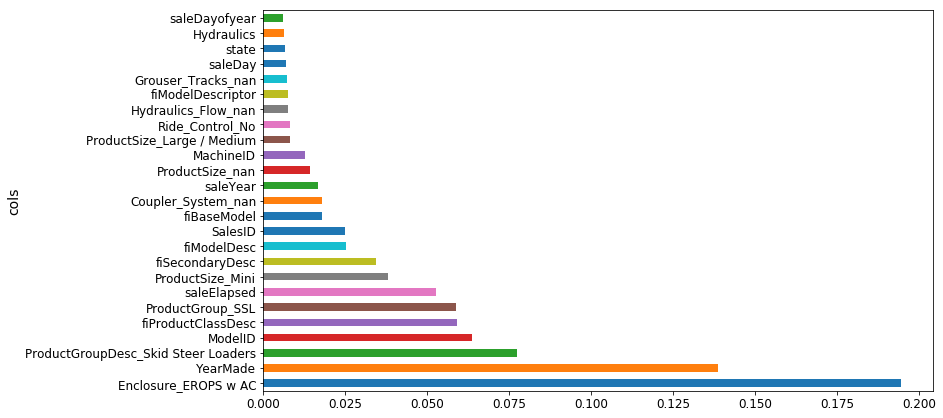

In [27]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [28]:
from scipy.cluster import hierarchy as hc

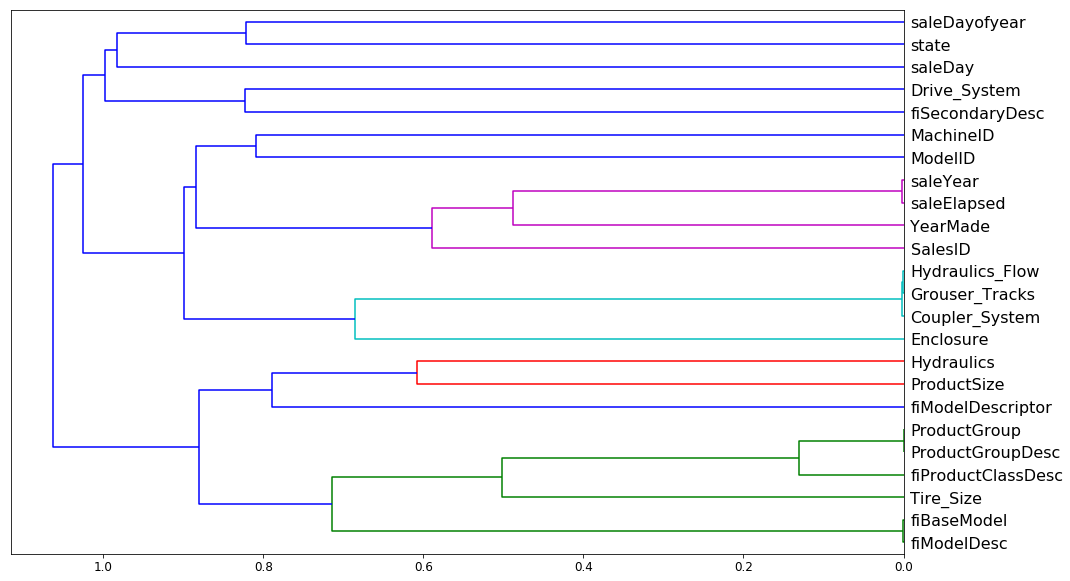

In [29]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [30]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [31]:
get_oob(df_keep)

0.8904457135911582

Now we try removing each variable one at a time.

In [32]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8891690058494455
saleElapsed 0.8856576451811838
fiModelDesc 0.8888498318966384
fiBaseModel 0.8896576569269056
Grouser_Tracks 0.8895071210079402
Coupler_System 0.8901381818402135


It looks like we can try one from each group for removal. Let's see what that does.

In [33]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8882064301863095

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [34]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [35]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [36]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [37]:
reset_rf_samples()

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12572464251876952, 0.22635918185361317, 0.9669648985419317, 0.9084951306835531, 0.9087343887617304]


# Partial dependence

In [39]:
from pdpbox import pdp
from plotnine import *

ModuleNotFoundError: No module named 'pdpbox'

In [40]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [41]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

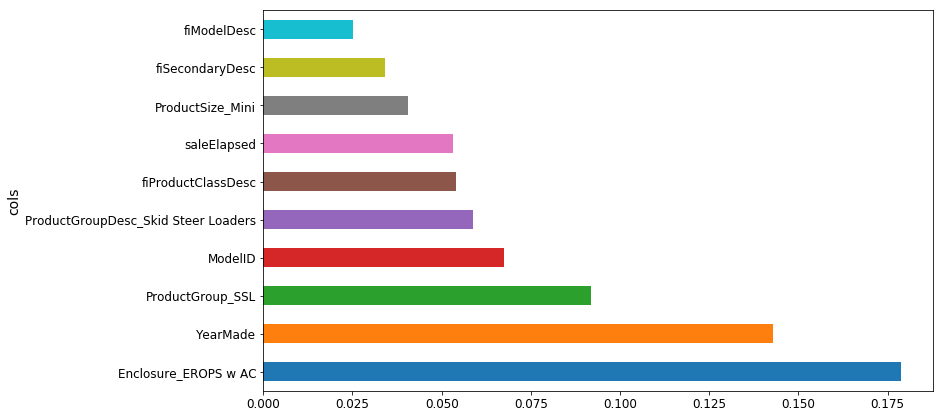

In [42]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

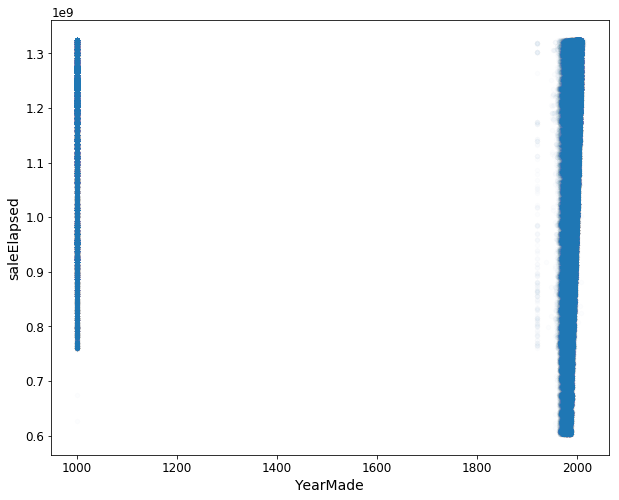

In [43]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [44]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

# Tree interpreter

In [54]:
from treeinterpreter import treeinterpreter as ti

In [55]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [56]:
row = X_valid.values[None,0]; row

array([[4364751, 2300944, 665, 172, 1.0, 1999, 3726.0, 2, 3232, 1111, 0, 63, 0, 17, 35, 0, 12, 0, 19, 29, 0,
        2010, 9, 37, 16, 3, 259, False, False, False, False, False, False, 1284595200, False, False, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]],
      dtype=object)

In [57]:
prediction, bias, contributions = ti.predict(m, row)

In [58]:
prediction[0], bias[0]

(array([9.23253]), 10.105453961070396)

In [59]:
idxs = np.argsort(contributions[0])

In [60]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

IndexError: index 40 is out of bounds for axis 1 with size 22

In [61]:
contributions[0].sum()

-0.8729229166194188

# Extrapolation

In [62]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

C:\Users\Kalmerrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [64]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.833760
5,saleElapsed,0.115391
12,MachineID,0.041612
19,saleDayofyear,0.002549
0,YearMade,0.001439
21,age,0.001219
7,Enclosure,0.001017
4,ModelID,0.000882
1,Coupler_System,0.000570
16,Hydraulics,0.000402


In [65]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [66]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [67]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [68]:
x.drop(feats, axis=1, inplace=True)

In [69]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9785802430663758

In [70]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.229697
0,YearMade,0.186120
16,saleDayofyear,0.158367
4,ModelID,0.080352
8,fiModelDesc,0.062878
15,saleDay,0.058779
14,state,0.056952
3,fiProductClassDesc,0.034132
5,fiSecondaryDesc,0.022732
13,Hydraulics,0.022345


In [71]:
set_rf_samples(50000)

In [72]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [73]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20757667246388548, 0.24768858231233015, 0.9099482996387624, 0.8904380006819352, 0.8933810239399059]


In [74]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20922628273472396, 0.24503957297318196, 0.908511332066656, 0.8927689822675575, 0.8923504544027875]
saleElapsed
[0.21438596078103064, 0.25458764779923626, 0.9039433337697185, 0.8842495652034227, 0.886866417505291]
MachineID
[0.20713067136979774, 0.24640401847192966, 0.9103348556900798, 0.8915714758678234, 0.8946935594166232]
age
[0.20992831604567264, 0.24866900116506674, 0.9078963438692486, 0.8895689316207434, 0.8912731544046739]
YearMade
[0.20900337884576692, 0.25122056154702094, 0.9087061672130516, 0.8872910670835309, 0.8922251496652126]
saleDayofyear
[0.20952342651593447, 0.24505158254471116, 0.908251282586395, 0.8927584710662853, 0.8920885436231034]


In [75]:
reset_rf_samples()

In [76]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13849287719019324, 0.21797356975203733, 0.9599142787853518, 0.9151492574336337, 0.9092142196107607]


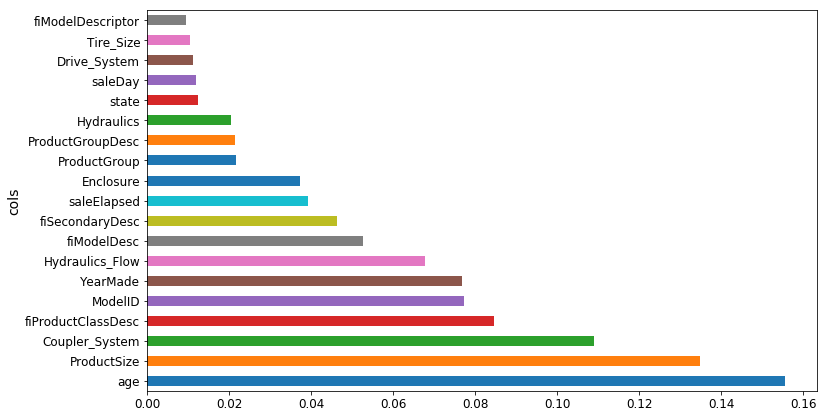

In [77]:
plot_fi(rf_feat_importance(m, X_train));

In [78]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [79]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 2min
[0.08018238376078128, 0.21178739968128416, 0.9865632959170911, 0.9198971053609248, 0.9146087244705404]
